## NYUD - joint semantic segmentation and depth estimation

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import scipy.misc

In [2]:
import sys
sys.path.append('../')
from models import net

In [3]:
import cv2

In [4]:
import torch
from torch.autograd import Variable

In [5]:
# Pre-processing and post-processing constants #
CMAP = np.load('../cmap_nyud.npy')
DEPTH_COEFF = 5000. # to convert into metres
HAS_CUDA = torch.cuda.is_available()
IMG_SCALE  = 1./255
IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))
MAX_DEPTH = 8.
MIN_DEPTH = 0.
NUM_CLASSES = 40
NUM_TASKS = 2 # segm + depth

In [6]:
def prepare_img(img):
    return (img * IMG_SCALE - IMG_MEAN) / IMG_STD

In [7]:
model = net(num_classes=NUM_CLASSES, num_tasks=NUM_TASKS)
if HAS_CUDA:
    _ = model.cuda()
_ = model.eval()

In [8]:
ckpt = torch.load('../../weights/ExpNYUD_joint.ckpt')
model.load_state_dict(ckpt['state_dict'])

In [11]:
# Figure 2-top row
img_path = '/home/tourani/Desktop/code/multi-task-refinenet/src/notebooks/synth.jpg'
img = np.array(Image.open(img_path))
gt_segm = np.array(Image.open('../../examples/ExpNYUD_joint/segm_gt_000464.png'))
gt_depth = np.array(Image.open('../../examples/ExpNYUD_joint/depth_gt_000464.png'))

/home/tourani/Desktop/code/multi-task-refinenet/multienv/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


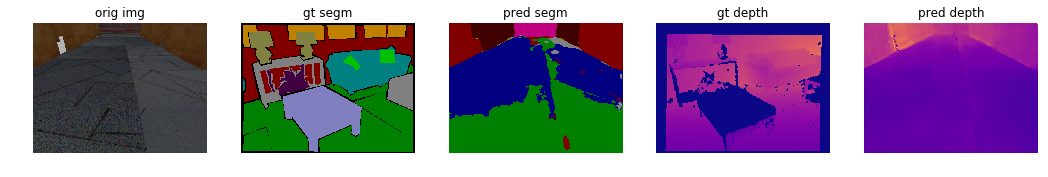

In [14]:
with torch.no_grad():
    img_var = Variable(torch.from_numpy(prepare_img(img).transpose(2, 0, 1)[None]), requires_grad=False).float()
    if HAS_CUDA:
        img_var = img_var.cuda()
    segm, depth = model(img_var)
    segm = cv2.resize(segm[0, :NUM_CLASSES].cpu().data.numpy().transpose(1, 2, 0),
                      img.shape[:2][::-1],
                      interpolation=cv2.INTER_CUBIC)
    depth = cv2.resize(depth[0, 0].cpu().data.numpy(),
                       img.shape[:2][::-1],
                       interpolation=cv2.INTER_CUBIC)
    segm = CMAP[segm.argmax(axis=2) + 1].astype(np.uint8)
    depth = np.abs(depth)
    scipy.misc.imsave('outfile3.jpg', segm)
plt.figure(figsize=(18, 12))
plt.subplot(151)
plt.imshow(img)
plt.title('orig img')
plt.axis('off')
plt.subplot(152)
plt.imshow(CMAP[gt_segm + 1])
plt.title('gt segm')
plt.axis('off')
plt.subplot(153)
plt.imshow(segm)
plt.title('pred segm')
plt.axis('off')
plt.subplot(154)
plt.imshow(gt_depth / DEPTH_COEFF, cmap='plasma', vmin=MIN_DEPTH, vmax=MAX_DEPTH)
plt.title('gt depth')
plt.axis('off')
plt.subplot(155)
plt.imshow(depth, cmap='plasma', vmin=MIN_DEPTH, vmax=MAX_DEPTH)
plt.title('pred depth')
plt.axis('off');